In [1]:
#general package
import pandas as pd
import numpy as np
import json
import os
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Define a color map
import matplotlib.cm as cm 

#statistical package
from scipy.stats.stats import pearsonr
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy import stats

#dashboard package
import sweetviz as sv

## STEP 1:  Deriving the complete data frame: 
### i) cleaning the match_number;  ii) add the history performance

1.  There was one game where team2's half-time data was not found in the innings_data, probably because team2 did not play, which is the same game as one game 'no result', which was identified by the news that rain interrupted the game on that day, which is a very special case, so I chose to skip this game directly and created a data frame with only records This was a very special case, so I chose to skip the match and create this data frame with only 123 matches, or 246 rows of data.


2.  In "The Hundred" cricket there are 20 overs per team and each over has 5 deliveries, so the first half of the game is a count of team1's score and wicket player out only!! Team1 is the team that bats. For these teams, it is the half-time stats that have discriminatory power.


3.  Wicket type: Bowled; Caught; Run out; Leg before wicket (LBW); Stumped; Hit wicket; Handled the ball; Obstructing the field; Hit the ball twice; Timed out. This will not be used as a statistical variable for the time being.


In [2]:
folder_path = os.getcwd() + '/dissertation_dataset/hnd_json/'
data_frame_list = []

home_venues = {
    "Southern Brave": "The Rose Bowl, Southampton",
    "Birmingham Phoenix": "Edgbaston, Birmingham",
    "Trent Rockets": "Trent Bridge, Nottingham",
    "Oval Invincibles": "Kennington Oval, London",
    "London Spirit": "Lord's, London",
    "Welsh Fire": "Sophia Gardens, Cardiff",
    "Manchester Originals": "Old Trafford, Manchester",
    "Northern Superchargers": "Headingley, Leeds"}

def calculate_scores_and_wickets_per_inning(data_dict, team):
    score = 0
    wickets = 0
    for innings in data_dict["innings"]:
        if innings["team"] == team:
            for over in innings["overs"]:
                for delivery in over["deliveries"]:
                    score += delivery["runs"]["total"]
                    if "wickets" in delivery:
                        wickets += len(delivery["wickets"])
            break
    return score, wickets

for file_name in os.listdir(folder_path):
    if file_name.endswith('.json'):
        with open(os.path.join(folder_path, file_name), 'r') as f:
            data_dict = json.load(f)
            
            info_data = data_dict['info']

            team1 = info_data['teams'][0]
            team2 = info_data['teams'][1]
            
            gender = info_data['gender']
            season = info_data['season']
            
            date = info_data['dates'][0]
            
            match_number = info_data['event'].get('match_number', 'unknown')  
            
            venue = info_data['venue']
            city = info_data['city']
                    
            home_advantage_team1 = 'yes' if home_venues[team1] == venue else 'no'
            home_advantage_team2 = 'yes' if home_venues[team2] == venue else 'no'
            #home_advantage and toss_winner may be strong relationship          
            
            toss_winner = info_data['toss']['winner']
            toss_decision = info_data['toss']['decision']
            
            choose_to_bat_team1, choose_to_field_team1, forced_to_bat_team1, forced_to_field_team1 = 'no', 'no', 'no', 'no'
            choose_to_bat_team2, choose_to_field_team2, forced_to_bat_team2, forced_to_field_team2 = 'no', 'no', 'no', 'no'
 
            if toss_decision == 'bat':
                if toss_winner == team1:
                    choose_to_bat_team1 = 'yes'
                    forced_to_field_team2 = 'yes'
                else:
                    choose_to_bat_team2 = 'yes'
                    forced_to_field_team1 = 'yes'
            else:
                if toss_winner == team1:
                    choose_to_field_team1 = 'yes'
                    forced_to_bat_team2 = 'yes'
                else:
                    choose_to_field_team2 = 'yes'
                    forced_to_bat_team1 = 'yes'
            #choose_to_bat and toss_winner may be strong relationship
          
            # Set the reverse decision for the losing team based on the toss decision
            toss_decision_loser = 'field' if toss_decision == 'bat' else 'bat'
            toss_decision_team1 = toss_decision if toss_winner == team1 else toss_decision_loser
            toss_decision_team2 = toss_decision if toss_winner == team2 else toss_decision_loser
            
            winner = info_data['outcome'].get('winner', 'no winner')  

            result_team1 = 'win' if winner == team1 else ('lose' if winner == team2 else 'no result')
            result_team2 = 'win' if winner == team2 else ('lose' if winner == team1 else 'no result')
            if result_team1 == 'no result' or result_team2 == 'no result':
                continue
            
            first_inning_score, first_inning_wickets = calculate_scores_and_wickets_per_inning(data_dict, team1)
            second_inning_score, second_inning_wickets = calculate_scores_and_wickets_per_inning(data_dict, team2)

            win_by_runs = 0
            win_by_wickets = 0
            if winner == team1 and first_inning_score > second_inning_score:
                win_by_runs = first_inning_score - second_inning_score
            elif winner == team2 and second_inning_score > first_inning_score:
                win_by_wickets = 10 - second_inning_wickets  
            #Assuming 10 wickets in an inning
                          
        data_frame_list.append([result_team1, 
                                team1, team2, gender, season, date, match_number, 
                                venue, city, home_advantage_team1, 
                                toss_winner, toss_decision_team1, 
                                choose_to_bat_team1, choose_to_field_team1, forced_to_bat_team1, forced_to_field_team1,  
                                winner, first_inning_score, first_inning_wickets,
                                win_by_runs, win_by_wickets])

        data_frame_list.append([result_team2, 
                                team2, team1, gender, season, date, match_number, 
                                venue, city, home_advantage_team2, 
                                toss_winner, toss_decision_team2, 
                                choose_to_bat_team2, choose_to_field_team2, forced_to_bat_team2, forced_to_field_team2, 
                                winner, second_inning_score, second_inning_wickets, 
                                win_by_runs, win_by_wickets])

df = pd.DataFrame(data_frame_list, columns=['Result',
                                            'team', 'opponent', 'gender', 'season','date', 
                                            'match_number',
                                            'venue', 'city', 'home_advantage',
                                            'toss_winner', 'toss_decision', 
                                            'choose_to_bat', 'choose_to_field', 'forced_to_bat', 'forced_to_field',
                                            'winner',
                                            'team_score', 'team_wickets', 'win_by_runs', 'win_by_wickets'])

In [3]:
# convert 'date' to datetime object
df['date'] = pd.to_datetime(df['date'])

# sort by 'season' and 'date'
df = df.sort_values(by=['season', 'date'])

df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df = df.drop(columns=['date'])

column_order = ['Result','match_number',  
                'team', 'opponent',
                'gender', 'season', 
                'month','day', 
                'home_advantage','venue', 'city', 
                'toss_winner', 'toss_decision',
                'winner',
                'team_score','team_wickets',
                'win_by_runs','win_by_wickets',
                'choose_to_bat', 'choose_to_field', 'forced_to_bat', 'forced_to_field']
                                            

df = df[column_order]
df= df.reset_index(drop=True)

In [4]:
df #Initial traversal of the completed double layer data frame

,Result,match_number,team,opponent,gender,season,month,day,home_advantage,venue,...,toss_decision,winner,team_score,team_wickets,win_by_runs,win_by_wickets,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field
0,lose,1,Manchester Originals,Oval Invincibles,female,2021,7,21,no,"Kennington Oval, London",...,bat,Oval Invincibles,135,6,0,5,yes,no,no,no
1,win,1,Oval Invincibles,Manchester Originals,female,2021,7,21,yes,"Kennington Oval, London",...,field,Oval Invincibles,139,5,0,5,no,no,no,yes
2,win,1,Oval Invincibles,Manchester Originals,male,2021,7,22,yes,"Kennington Oval, London",...,bat,Oval Invincibles,145,8,9,0,no,no,yes,no
3,lose,1,Manchester Originals,Oval Invincibles,male,2021,7,22,no,"Kennington Oval, London",...,field,Oval Invincibles,136,7,9,0,no,yes,no,no
4,lose,2,Birmingham Phoenix,London Spirit,female,2021,7,23,yes,"Edgbaston, Birmingham",...,bat,London Spirit,128,6,0,3,no,no,yes,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241,lose,unknown,Trent Rockets,Southern Brave,female,2022,9,2,no,"The Rose Bowl, Southampton",...,field,Southern Brave,132,7,2,0,no,yes,no,no
242,lose,unknown,Manchester Originals,Trent Rockets,male,2022,9,3,no,"Lord's, London",...,bat,Trent Rockets,120,9,0,2,yes,no,no,no
243,win,unknown,Trent Rockets,Manchester Originals,male,2022,9,3,no,"Lord's, London",...,field,Trent Rockets,121,8,0,2,no,no,no,yes
244,lose,unknown,Southern Brave,Oval Invincibles,female,2022,9,3,no,"Lord's, London",...,bat,Oval Invincibles,101,7,0,5,yes,no,no,no


## STEP1.1: about 'match_number' (unknown: eliminator, assigned 40; final, assigned 50 )

8 matches without a match number all had a common date: 
2021-08-20, 
2021-08-21,
2022-09-02, 
2022-09-03.

Those without match numbers are eliminators and finals, while the maximum match number for women's cricket in 2022 is known to be 22 and the maximum match number for all three types of matches, 2022 men, 2021 men and 2021 women, is 32. To distinguish significantly between the eliminators and finals, assign a value of 40 to the eliminators and 50 to the finals.

In [5]:
matches_without_number = df[df.iloc[:,1]=='unknown'] #8 matches 16rows
matches_without_number

,Result,match_number,team,opponent,gender,season,month,day,home_advantage,venue,...,toss_decision,winner,team_score,team_wickets,win_by_runs,win_by_wickets,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field
118,lose,unknown,Trent Rockets,Southern Brave,male,2021,8,20,no,"Kennington Oval, London",...,bat,Southern Brave,96,10,0,7,no,no,yes,no
119,win,unknown,Southern Brave,Trent Rockets,male,2021,8,20,no,"Kennington Oval, London",...,field,Southern Brave,97,3,0,7,no,yes,no,no
120,win,unknown,Oval Invincibles,Birmingham Phoenix,female,2021,8,20,yes,"Kennington Oval, London",...,bat,Oval Invincibles,114,7,20,0,no,no,yes,no
121,lose,unknown,Birmingham Phoenix,Oval Invincibles,female,2021,8,20,no,"Kennington Oval, London",...,field,Oval Invincibles,94,10,20,0,no,yes,no,no
122,win,unknown,Southern Brave,Birmingham Phoenix,male,2021,8,21,no,"Lord's, London",...,bat,Southern Brave,168,5,32,0,no,no,yes,no
123,lose,unknown,Birmingham Phoenix,Southern Brave,male,2021,8,21,no,"Lord's, London",...,field,Southern Brave,136,5,32,0,no,yes,no,no
124,win,unknown,Oval Invincibles,Southern Brave,female,2021,8,21,no,"Lord's, London",...,bat,Oval Invincibles,121,6,48,0,no,no,yes,no
125,lose,unknown,Southern Brave,Oval Invincibles,female,2021,8,21,no,"Lord's, London",...,field,Oval Invincibles,73,10,48,0,no,yes,no,no
238,lose,unknown,London Spirit,Manchester Originals,male,2022,9,2,no,"The Rose Bowl, Southampton",...,bat,Manchester Originals,150,7,0,5,yes,no,no,no
239,win,unknown,Manchester Originals,London Spirit,male,2022,9,2,no,"The Rose Bowl, Southampton",...,field,Manchester Originals,151,5,0,5,no,no,no,yes


In [6]:
# Exclude rows where match_number is 'unknown'
matches_with_number = df[df['match_number'] != 'unknown']

# Convert the match_number column to integers
matches_with_number['match_number'] = matches_with_number['match_number'].astype(int)

# Check the minimum, maximum and the distribution of match numbers
min_match_number = matches_with_number['match_number'].min()
max_match_number = matches_with_number['match_number'].max()
distribution = matches_with_number['match_number'].value_counts().sort_index()

print(f'Minimum match number: {min_match_number}\n')
print(f'Maximum match number: {max_match_number}\n')
print('Distribution of match numbers:')
print('--------------------------------')
for num, count in distribution.items():
    print(f'Match Number: {num} -> Count: {count}')

Minimum match number: 1

Maximum match number: 32

Distribution of match numbers:
--------------------------------
Match Number: 1 -> Count: 8
Match Number: 2 -> Count: 8
Match Number: 3 -> Count: 8
Match Number: 4 -> Count: 8
Match Number: 5 -> Count: 6
Match Number: 6 -> Count: 8
Match Number: 7 -> Count: 8
Match Number: 8 -> Count: 8
Match Number: 9 -> Count: 4
Match Number: 10 -> Count: 8
Match Number: 11 -> Count: 8
Match Number: 12 -> Count: 8
Match Number: 13 -> Count: 8
Match Number: 14 -> Count: 8
Match Number: 15 -> Count: 8
Match Number: 16 -> Count: 8
Match Number: 17 -> Count: 8
Match Number: 18 -> Count: 8
Match Number: 19 -> Count: 6
Match Number: 20 -> Count: 8
Match Number: 21 -> Count: 8
Match Number: 22 -> Count: 6
Match Number: 23 -> Count: 8
Match Number: 24 -> Count: 8
Match Number: 25 -> Count: 6
Match Number: 26 -> Count: 6
Match Number: 27 -> Count: 6
Match Number: 28 -> Count: 6
Match Number: 29 -> Count: 6
Match Number: 30 -> Count: 6
Match Number: 31 -> Coun

/var/folders/1v/gbft9lh97dggng6ytnnwkd9c0000gn/T/ipykernel_6711/1754600911.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matches_with_number['match_number'] = matches_with_number['match_number'].astype(int)


### Observation obtained:


2021 men's team match_number is missing 5, 9 and 19;

2021 women's team match_number is missing 9 and 22;
   
2022 men's team match_number from 1-32 not missing;
   
2022 women's team match_number is missing 25-32;

The women's competition was curtailed due to the inclusion of women's cricket at the 2022 Commonwealth Games in Birmingham, reducing the number of players who were available for the start of the contest. As a result, the women's contest started a week later and each women's team only played six matches in the group stage, meaning some sides did not meet each other at that point in the competition.




### Cleaning: assigning values to unknown match numbers

In [7]:
### Assign values
df['season'] = df['season'].astype(int)
df['month'] = df['month'].astype(int)
df['day'] = df['day'].astype(int)

def assign_match_number(row):
    if row['season'] == 2021 and row['month'] == 8 and row['day'] == 20:
        return 40  # semi-finals
    elif row['season'] == 2021 and row['month'] == 8 and row['day'] == 21:
        return 50  # finals
    elif row['season'] == 2022 and row['month'] == 9 and row['day'] == 2:
        return 40  # semi-finals
    elif row['season'] == 2022 and row['month'] == 9 and row['day'] == 3:
        return 50  # finals
    else:
        return row['match_number']  # keep the original match number

df['match_number'] = df.apply(assign_match_number, axis=1)

After assigning values, check them

In [8]:
df[df['match_number']==40]  #eliminators in two seasons

,Result,match_number,team,opponent,gender,season,month,day,home_advantage,venue,...,toss_decision,winner,team_score,team_wickets,win_by_runs,win_by_wickets,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field
118,lose,40,Trent Rockets,Southern Brave,male,2021,8,20,no,"Kennington Oval, London",...,bat,Southern Brave,96,10,0,7,no,no,yes,no
119,win,40,Southern Brave,Trent Rockets,male,2021,8,20,no,"Kennington Oval, London",...,field,Southern Brave,97,3,0,7,no,yes,no,no
120,win,40,Oval Invincibles,Birmingham Phoenix,female,2021,8,20,yes,"Kennington Oval, London",...,bat,Oval Invincibles,114,7,20,0,no,no,yes,no
121,lose,40,Birmingham Phoenix,Oval Invincibles,female,2021,8,20,no,"Kennington Oval, London",...,field,Oval Invincibles,94,10,20,0,no,yes,no,no
238,lose,40,London Spirit,Manchester Originals,male,2022,9,2,no,"The Rose Bowl, Southampton",...,bat,Manchester Originals,150,7,0,5,yes,no,no,no
239,win,40,Manchester Originals,London Spirit,male,2022,9,2,no,"The Rose Bowl, Southampton",...,field,Manchester Originals,151,5,0,5,no,no,no,yes
240,win,40,Southern Brave,Trent Rockets,female,2022,9,2,yes,"The Rose Bowl, Southampton",...,bat,Southern Brave,134,6,2,0,no,no,yes,no
241,lose,40,Trent Rockets,Southern Brave,female,2022,9,2,no,"The Rose Bowl, Southampton",...,field,Southern Brave,132,7,2,0,no,yes,no,no


In [9]:
df[df['match_number']==50] #finals in two seasons

,Result,match_number,team,opponent,gender,season,month,day,home_advantage,venue,...,toss_decision,winner,team_score,team_wickets,win_by_runs,win_by_wickets,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field
122,win,50,Southern Brave,Birmingham Phoenix,male,2021,8,21,no,"Lord's, London",...,bat,Southern Brave,168,5,32,0,no,no,yes,no
123,lose,50,Birmingham Phoenix,Southern Brave,male,2021,8,21,no,"Lord's, London",...,field,Southern Brave,136,5,32,0,no,yes,no,no
124,win,50,Oval Invincibles,Southern Brave,female,2021,8,21,no,"Lord's, London",...,bat,Oval Invincibles,121,6,48,0,no,no,yes,no
125,lose,50,Southern Brave,Oval Invincibles,female,2021,8,21,no,"Lord's, London",...,field,Oval Invincibles,73,10,48,0,no,yes,no,no
242,lose,50,Manchester Originals,Trent Rockets,male,2022,9,3,no,"Lord's, London",...,bat,Trent Rockets,120,9,0,2,yes,no,no,no
243,win,50,Trent Rockets,Manchester Originals,male,2022,9,3,no,"Lord's, London",...,field,Trent Rockets,121,8,0,2,no,no,no,yes
244,lose,50,Southern Brave,Oval Invincibles,female,2022,9,3,no,"Lord's, London",...,bat,Oval Invincibles,101,7,0,5,yes,no,no,no
245,win,50,Oval Invincibles,Southern Brave,female,2022,9,3,no,"Lord's, London",...,field,Oval Invincibles,105,5,0,5,no,no,no,yes


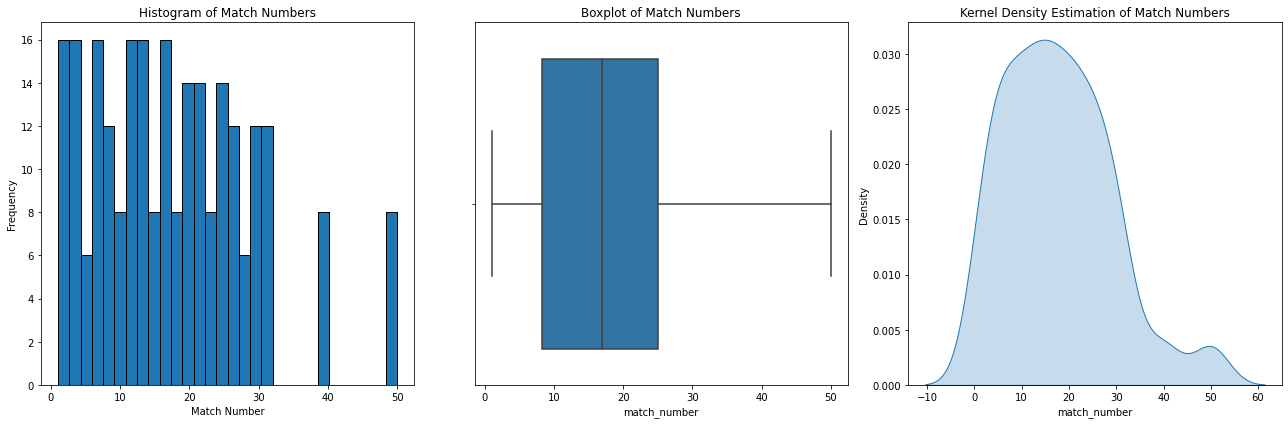

In [10]:
df_copy = df.copy()
df_copy['match_number'] = pd.to_numeric(df_copy['match_number'], errors='coerce')

match_numbers = df_copy['match_number'].dropna()

fig, axs = plt.subplots(1, 3, figsize=(18, 6)) 

axs[0].hist(match_numbers, bins=30, edgecolor='black')
axs[0].set_title('Histogram of Match Numbers')
axs[0].set_xlabel('Match Number')
axs[0].set_ylabel('Frequency')

sns.boxplot(x=match_numbers, ax=axs[1])  
axs[1].set_title('Boxplot of Match Numbers')

sns.kdeplot(data=match_numbers, fill=True, ax=axs[2])
axs[2].set_title('Kernel Density Estimation of Match Numbers')

plt.tight_layout()  
plt.savefig('/Users/quinne/Desktop/dissertation_picture/match_numbers.png') 
plt.show()

In [11]:
####Check the distribution after the assignment
def check_match_number_distribution(group):
    group_name = group.name
    matches_with_number = group[pd.to_numeric(group['match_number'], errors='coerce').notna()]   
    matches_with_number['match_number'] = matches_with_number['match_number'].astype(int)

    min_match_number = matches_with_number['match_number'].min()
    max_match_number = matches_with_number['match_number'].max()
    distribution = matches_with_number['match_number'].value_counts().sort_index()

    print(f'For group {group_name}:')
    print(f'Minimum match number: {min_match_number}')
    print(f'Maximum match number: {max_match_number}')
    print('Distribution of match numbers:')
    print(distribution)
    print('--------------------')

df.groupby(['season', 'gender']).apply(check_match_number_distribution)

For group (2021, 'female'):
Minimum match number: 1
Maximum match number: 50
Distribution of match numbers:
1     2
2     2
3     2
4     2
5     2
6     2
7     2
8     2
10    2
11    2
12    2
13    2
14    2
15    2
16    2
17    2
18    2
19    2
20    2
21    2
23    2
24    2
25    2
26    2
27    2
28    2
29    2
30    2
31    2
32    2
40    2
50    2
Name: match_number, dtype: int64
--------------------
For group (2021, 'male'):
Minimum match number: 1
Maximum match number: 50
Distribution of match numbers:
1     2
2     2
3     2
4     2
6     2
7     2
8     2
10    2
11    2
12    2
13    2
14    2
15    2
16    2
17    2
18    2
20    2
21    2
22    2
23    2
24    2
25    2
26    2
27    2
28    2
29    2
30    2
31    2
32    2
40    2
50    2
Name: match_number, dtype: int64
--------------------
For group (2022, 'female'):
Minimum match number: 1
Maximum match number: 50
Distribution of match numbers:
1     2
2     2
3     2
4     2
5     2
6     2
7     2
8     2
9 

""


In [12]:
### Having already assigned the missing values in match_number
###the whole df_bat can be divided into four subsets according to season and male and female
###looking at them from smallest to largest match number

df_2021 = df.loc[df['season'] == 2021] 
df_2022 = df.loc[df['season'] == 2022] 

df_2021_men = df_2021.loc[df_2021['gender'] == 'male'] 
df_2021_women = df_2021.loc[df_2021['gender'] == 'female'] 
df_2022_men = df_2022.loc[df_2022['gender'] == 'male'] 
df_2022_women = df_2022.loc[df_2022['gender'] == 'female']

df_2021_men = df_2021_men.sort_values('match_number')
df_2021_women = df_2021_women.sort_values('match_number')
df_2022_men = df_2022_men.sort_values('match_number')
df_2022_women = df_2022_women.sort_values('match_number')

In [13]:
df_2021_men 
#2021 men's team match_number is missing 5, 9 and 19;
#31 matches, with the deletion of the one with no result
#19th Match (N), Manchester, August 05, 2021

,Result,match_number,team,opponent,gender,season,month,day,home_advantage,venue,...,toss_decision,winner,team_score,team_wickets,win_by_runs,win_by_wickets,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field
2,win,1,Oval Invincibles,Manchester Originals,male,2021,7,22,yes,"Kennington Oval, London",...,bat,Oval Invincibles,145,8,9,0,no,no,yes,no
3,lose,1,Manchester Originals,Oval Invincibles,male,2021,7,22,no,"Kennington Oval, London",...,field,Oval Invincibles,136,7,9,0,no,yes,no,no
6,lose,2,London Spirit,Birmingham Phoenix,male,2021,7,23,no,"Edgbaston, Birmingham",...,bat,Birmingham Phoenix,144,6,0,3,no,no,yes,no
7,win,2,Birmingham Phoenix,London Spirit,male,2021,7,23,yes,"Edgbaston, Birmingham",...,field,Birmingham Phoenix,148,7,0,3,no,yes,no,no
8,lose,3,Southern Brave,Trent Rockets,male,2021,7,24,no,"Trent Bridge, Nottingham",...,bat,Trent Rockets,126,8,0,9,yes,no,no,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,win,32,Welsh Fire,London Spirit,male,2021,8,18,yes,"Sophia Gardens, Cardiff",...,field,Welsh Fire,165,7,0,3,no,yes,no,no
118,lose,40,Trent Rockets,Southern Brave,male,2021,8,20,no,"Kennington Oval, London",...,bat,Southern Brave,96,10,0,7,no,no,yes,no
119,win,40,Southern Brave,Trent Rockets,male,2021,8,20,no,"Kennington Oval, London",...,field,Southern Brave,97,3,0,7,no,yes,no,no
122,win,50,Southern Brave,Birmingham Phoenix,male,2021,8,21,no,"Lord's, London",...,bat,Southern Brave,168,5,32,0,no,no,yes,no


In [14]:
df_2021_women #32 matches
#2021 women's team match_number is missing 9 and 22;

,Result,match_number,team,opponent,gender,season,month,day,home_advantage,venue,...,toss_decision,winner,team_score,team_wickets,win_by_runs,win_by_wickets,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field
0,lose,1,Manchester Originals,Oval Invincibles,female,2021,7,21,no,"Kennington Oval, London",...,bat,Oval Invincibles,135,6,0,5,yes,no,no,no
1,win,1,Oval Invincibles,Manchester Originals,female,2021,7,21,yes,"Kennington Oval, London",...,field,Oval Invincibles,139,5,0,5,no,no,no,yes
4,lose,2,Birmingham Phoenix,London Spirit,female,2021,7,23,yes,"Edgbaston, Birmingham",...,bat,London Spirit,128,6,0,3,no,no,yes,no
5,win,2,London Spirit,Birmingham Phoenix,female,2021,7,23,no,"Edgbaston, Birmingham",...,field,London Spirit,132,7,0,3,no,yes,no,no
14,win,3,Southern Brave,Trent Rockets,female,2021,7,24,no,"Trent Bridge, Nottingham",...,bat,Southern Brave,133,5,23,0,no,no,yes,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,win,32,London Spirit,Welsh Fire,female,2021,8,18,no,"Sophia Gardens, Cardiff",...,field,London Spirit,96,3,0,7,no,yes,no,no
120,win,40,Oval Invincibles,Birmingham Phoenix,female,2021,8,20,yes,"Kennington Oval, London",...,bat,Oval Invincibles,114,7,20,0,no,no,yes,no
121,lose,40,Birmingham Phoenix,Oval Invincibles,female,2021,8,20,no,"Kennington Oval, London",...,field,Oval Invincibles,94,10,20,0,no,yes,no,no
124,win,50,Oval Invincibles,Southern Brave,female,2021,8,21,no,"Lord's, London",...,bat,Oval Invincibles,121,6,48,0,no,no,yes,no


In [15]:
df_2022_men #32 matches +2 matches (Elimination and final)
#2022 men's team match_number from 1-32 not missing

,Result,match_number,team,opponent,gender,season,month,day,home_advantage,venue,...,toss_decision,winner,team_score,team_wickets,win_by_runs,win_by_wickets,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field
126,lose,1,Welsh Fire,Southern Brave,male,2022,8,3,no,"The Rose Bowl, Southampton",...,bat,Southern Brave,107,7,0,9,no,no,yes,no
127,win,1,Southern Brave,Welsh Fire,male,2022,8,3,yes,"The Rose Bowl, Southampton",...,field,Southern Brave,109,1,0,9,no,yes,no,no
128,win,2,London Spirit,Oval Invincibles,male,2022,8,4,no,"Kennington Oval, London",...,bat,London Spirit,171,6,3,0,no,no,yes,no
129,lose,2,Oval Invincibles,London Spirit,male,2022,8,4,yes,"Kennington Oval, London",...,field,London Spirit,168,7,3,0,no,yes,no,no
130,lose,3,Manchester Originals,Northern Superchargers,male,2022,8,5,yes,"Old Trafford, Manchester",...,bat,Northern Superchargers,161,4,0,6,no,no,yes,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
231,win,32,Manchester Originals,Oval Invincibles,male,2022,8,31,yes,"Old Trafford, Manchester",...,field,Manchester Originals,144,4,0,6,no,no,no,yes
238,lose,40,London Spirit,Manchester Originals,male,2022,9,2,no,"The Rose Bowl, Southampton",...,bat,Manchester Originals,150,7,0,5,yes,no,no,no
239,win,40,Manchester Originals,London Spirit,male,2022,9,2,no,"The Rose Bowl, Southampton",...,field,Manchester Originals,151,5,0,5,no,no,no,yes
242,lose,50,Manchester Originals,Trent Rockets,male,2022,9,3,no,"Lord's, London",...,bat,Trent Rockets,120,9,0,2,yes,no,no,no


In [16]:
df_2022_women 
#2022 women's team match_number is missing 25-32;
#24 matches +2 matches (Elimination and final)

#The following sides did not play each other in the group stage, 
#due to the shortened women's competition: 
#Oval Invincibles and Welsh Fire, 
#Northern Superchargers and Trent Rockets, 
#London Spirit and Manchester Originals, 
#Southern Brave and Birmingham Phoenix.

,Result,match_number,team,opponent,gender,season,month,day,home_advantage,venue,...,toss_decision,winner,team_score,team_wickets,win_by_runs,win_by_wickets,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field
142,lose,1,Northern Superchargers,Oval Invincibles,female,2022,8,11,no,"Kennington Oval, London",...,bat,Oval Invincibles,143,5,0,9,no,no,yes,no
143,win,1,Oval Invincibles,Northern Superchargers,female,2022,8,11,yes,"Kennington Oval, London",...,field,Oval Invincibles,146,1,0,9,no,yes,no,no
146,lose,2,London Spirit,Southern Brave,female,2022,8,12,no,"The Rose Bowl, Southampton",...,bat,Southern Brave,155,4,0,6,yes,no,no,no
147,win,2,Southern Brave,London Spirit,female,2022,8,12,yes,"The Rose Bowl, Southampton",...,field,Southern Brave,159,4,0,6,no,no,no,yes
152,win,3,Trent Rockets,Manchester Originals,female,2022,8,13,no,"Old Trafford, Manchester",...,bat,Trent Rockets,119,5,43,0,no,no,yes,no
153,lose,3,Manchester Originals,Trent Rockets,female,2022,8,13,yes,"Old Trafford, Manchester",...,field,Trent Rockets,76,10,43,0,no,yes,no,no
154,win,4,Birmingham Phoenix,Welsh Fire,female,2022,8,13,no,"Sophia Gardens, Cardiff",...,bat,Birmingham Phoenix,161,5,19,0,no,no,yes,no
155,lose,4,Welsh Fire,Birmingham Phoenix,female,2022,8,13,yes,"Sophia Gardens, Cardiff",...,field,Birmingham Phoenix,142,5,19,0,no,yes,no,no
164,win,5,Northern Superchargers,London Spirit,female,2022,8,14,yes,"Headingley, Leeds",...,bat,Northern Superchargers,127,4,5,0,no,no,yes,no
165,lose,5,London Spirit,Northern Superchargers,female,2022,8,14,no,"Headingley, Leeds",...,field,Northern Superchargers,122,7,5,0,no,yes,no,no


### Conclusion about 2 seasons of men's and women's matches

According to the official information:

1.    Both men's and women's cricket 2021 will have 32 matches each in the group stage, plus their respective semi-finals and finals, which should give a total of 64+4=68 matches.
2.    However, due to incomplete data, the 2021 men's matches with match_numbers = 5,9,19('no result',deleted) and the 2021 women's matches with match_number = 9,22 are missing, making a total of 4 matches missing and 1 deleted, so the figure for 2021 is only 64 matches.
3.    For the 2022 men's group matches there are 32 matches, plus the semi-finals and finals, making a total of 34 matches;
4.    For the 2022 women's group matches there are 24 matches, plus the semi-finals and finals, making a total of 26 matches.

In [17]:
missing_matches = [
    {"Missing Match number": 5, "Date": "25th July", "Season": 2021, "Gender": "men", "Result": "No result (abandoned with a toss)", "Teams": ["London Spirit (Men)", "Oval Invincibles (Men)"]},
    {"Missing Match number": 9, "Date": "28th July", "Season": 2021, "Gender": "men", "Result": "Abandoned without a ball bowled", "Teams": ["Manchester Originals (Men)", "Northern Superchargers (Men)"]},
    {"Missing Match number": 19, "Date": "5th August", "Season": 2021, "Gender": "men", "Result": "No results due to weather", "Teams": ["Manchester Originals (Men)", "Southern Brave (Men)"]},
    {"Missing Match number": 9, "Date": "28th July", "Season": 2021, "Gender": "women", "Result": "Abandoned without a ball bowled", "Teams": ["Manchester Originals (Women)", "Northern Superchargers (Women)"]},
    {"Missing Match number": 22, "Date": "8th August", "Season": 2021, "Gender": "women", "Result": "No result (abandoned with a toss)", "Teams": ["Oval Invincibles (Women)", "Trent Rockets (Women)"]},
    {"Missing Match number": "25-32", "Date": "/", "Season": 2022, "Gender": "women", "Result": "trimmed due to Commonwealth Games clash", "Teams": []},
]

missing_data = {
    "Missing Match number": [5, 9, 19, 9, 22, "25-32"],
    "Date": ["25th July", "28th July", "5th August", "28th July", "8th August", "/"],
    "Season": [2021, 2021, 2021, 2021, 2021, 2022],
    "Gender": ["men", "men", "men", "women", "women", "women"],
    "Result": ["No result (abandoned with a toss)", "Abandoned without a ball bowled", "No results due to weather", "Abandoned without a ball bowled", "No result (abandoned with a toss)", 
               "trimmed due to Commonwealth Games clash"],
    "Team 1": ["London Spirit (Men)", "Manchester Originals (Men)", "Manchester Originals (Men)", "Manchester Originals (Women)", "Oval Invincibles (Women)", None],
    "Team 2": ["Oval Invincibles (Men)", "Northern Superchargers (Men)", "Southern Brave (Men)", "Northern Superchargers (Women)", "Trent Rockets (Women)", None],
}

df_missing = pd.DataFrame(missing_data)
df_missing

,Missing Match number,Date,Season,Gender,Result,Team 1,Team 2
0,5,25th July,2021,men,No result (abandoned with a toss),London Spirit (Men),Oval Invincibles (Men)
1,9,28th July,2021,men,Abandoned without a ball bowled,Manchester Originals (Men),Northern Superchargers (Men)
2,19,5th August,2021,men,No results due to weather,Manchester Originals (Men),Southern Brave (Men)
3,9,28th July,2021,women,Abandoned without a ball bowled,Manchester Originals (Women),Northern Superchargers (Women)
4,22,8th August,2021,women,No result (abandoned with a toss),Oval Invincibles (Women),Trent Rockets (Women)
5,25-32,/,2022,women,trimmed due to Commonwealth Games clash,None,None


<table>
<tr>
    <th><font color="blue" size="4">Season</font></th>
    <th><font color="red" size="4">2021</font></th>
    <th><font color="red" size="4">2022</font></th>
    <th><font color="green" size="4">Total matches</font></th>
</tr>
<tr>
    <td><font size="4">Men</font></td>
    <td><font size="4">29+2=31</font></td>
    <td><font size="4">32+2=34</font></td>
    <td><font size="4">65</font></td>
</tr>
<tr>
    <td><font size="4">Women</font></td>
    <td><font size="4">30+2=32</font></td>
    <td><font size="4">24+2=26</font></td>
    <td><font size="4">58</font></td>
</tr>
<tr>
    <td><b><font size="4">Total matches</font></b></td>
    <td><b><font size="4">63</font></b></td>
    <td><b><font size="4">60</font></b></td>
    <td><b><font size="4">123</font></b></td>
</tr>
</table>


## STEP1.2: four new variables about the team's historical performance

Note that: Sometimes teams appear in the 'opponent' rather than the 'team' column, so we need to consider historical performance in a large 'df' context (double dataframe above) rather than just in 'df_bat'.


| Variable Name | Description |
|---------------|-------------|
| Average Win Percentage | The average percentage of matches that a team has won in its history. Note that the statistics for men's and women's teams are differentiated even if the team names are the same. |
| Average Halftime Score | The average score a team achieves in the half-court during its history. Again, statistics are differentiated for men's and women's teams. |
| Average Number of Wickets Player Outs | The average number of times a player from the team has been out due to wickets. Differentiated statistics are provided for men's and women's teams. |
| Last Match Result | The result of the team's last match. This variable also differentiates between the statistics for men's and women's teams. |

In [18]:
#Reorder by team name, gender, season and match number
df = df.sort_values(['team', 'gender','season', 'match_number'])

df['Result_num'] = df['Result'].map({'win': 1, 'lose': 0})

df['avg_win_rate'] = df.groupby(['team', 'gender'])['Result_num'].apply(lambda x: x.shift().expanding().mean())
df['avg_score'] = df.groupby(['team', 'gender'])['team_score'].apply(lambda x: x.shift().expanding().mean())
df['avg_wickets_out'] = df.groupby(['team', 'gender'])['team_wickets'].apply(lambda x: x.shift().expanding().mean())

df['last_match_result'] = df.groupby(['team', 'gender'])['Result'].shift()

df.drop(['Result_num'], axis=1, inplace=True)
df_sorted = df.sort_values(["season", "gender", "match_number"])

In [19]:
df_sorted.head()

,Result,match_number,team,opponent,gender,season,month,day,home_advantage,venue,...,win_by_runs,win_by_wickets,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field,avg_win_rate,avg_score,avg_wickets_out,last_match_result
0,lose,1,Manchester Originals,Oval Invincibles,female,2021,7,21,no,"Kennington Oval, London",...,0,5,yes,no,no,no,NaN,NaN,NaN,NaN
1,win,1,Oval Invincibles,Manchester Originals,female,2021,7,21,yes,"Kennington Oval, London",...,0,5,no,no,no,yes,NaN,NaN,NaN,NaN
4,lose,2,Birmingham Phoenix,London Spirit,female,2021,7,23,yes,"Edgbaston, Birmingham",...,0,3,no,no,yes,no,NaN,NaN,NaN,NaN
5,win,2,London Spirit,Birmingham Phoenix,female,2021,7,23,no,"Edgbaston, Birmingham",...,0,3,no,yes,no,no,NaN,NaN,NaN,NaN
14,win,3,Southern Brave,Trent Rockets,female,2021,7,24,no,"Trent Bridge, Nottingham",...,23,0,no,no,yes,no,NaN,NaN,NaN,NaN


In [20]:
rows_with_na = df_sorted[df_sorted.isna().any(axis=1)]
rows_with_na #16rows 8-matches 

,Result,match_number,team,opponent,gender,season,month,day,home_advantage,venue,...,win_by_runs,win_by_wickets,choose_to_bat,choose_to_field,forced_to_bat,forced_to_field,avg_win_rate,avg_score,avg_wickets_out,last_match_result
0,lose,1,Manchester Originals,Oval Invincibles,female,2021,7,21,no,"Kennington Oval, London",...,0,5,yes,no,no,no,NaN,NaN,NaN,NaN
1,win,1,Oval Invincibles,Manchester Originals,female,2021,7,21,yes,"Kennington Oval, London",...,0,5,no,no,no,yes,NaN,NaN,NaN,NaN
4,lose,2,Birmingham Phoenix,London Spirit,female,2021,7,23,yes,"Edgbaston, Birmingham",...,0,3,no,no,yes,no,NaN,NaN,NaN,NaN
5,win,2,London Spirit,Birmingham Phoenix,female,2021,7,23,no,"Edgbaston, Birmingham",...,0,3,no,yes,no,no,NaN,NaN,NaN,NaN
14,win,3,Southern Brave,Trent Rockets,female,2021,7,24,no,"Trent Bridge, Nottingham",...,23,0,no,no,yes,no,NaN,NaN,NaN,NaN
15,lose,3,Trent Rockets,Southern Brave,female,2021,7,24,yes,"Trent Bridge, Nottingham",...,23,0,no,yes,no,no,NaN,NaN,NaN,NaN
13,win,4,Northern Superchargers,Welsh Fire,female,2021,7,24,yes,"Headingley, Leeds",...,0,6,no,yes,no,no,NaN,NaN,NaN,NaN
12,lose,4,Welsh Fire,Northern Superchargers,female,2021,7,24,no,"Headingley, Leeds",...,0,6,no,no,yes,no,NaN,NaN,NaN,NaN
3,lose,1,Manchester Originals,Oval Invincibles,male,2021,7,22,no,"Kennington Oval, London",...,9,0,no,yes,no,no,NaN,NaN,NaN,NaN
2,win,1,Oval Invincibles,Manchester Originals,male,2021,7,22,yes,"Kennington Oval, London",...,9,0,no,no,yes,no,NaN,NaN,NaN,NaN


#### The historical performance variable for the first four games of the first season for both men and women (all eight teams competed) is the na value because historical data are not available.

In [21]:
#save the full data frame (double:246*26)
df_sorted.reset_index(drop=True).to_csv('/Users/quinne/Desktop/dissertation_dataset/double_dataframe.csv', index=False)